# Multimodal Data Fusion - Project Work: Multi-Modal Physical Exercise Classification


In this project, real multi-modal data is studied by utilizing different techniques presented during the course. In addition, there is an optional task to try some different approaches to identify persons from the same dataset. Open MEx dataset from UCI machine learning repository is used. Idea is to apply different techniques to recognize physical exercises from wearable sensors and depth camera, user-independently.

## Author(s)
Add your information here

Name: Valtteri Vuorio

Student number: 2621775

## Description 

The goal of this project is to develop user-independent pre-processing and classification models to recognize 7 different physical exercises measured by accelerometer (attached to subject's thigh) and depth camera (above the subject facing downwards recording an aerial view). All the exercises were performed subject lying down on the mat. Original dataset have also another acceleration sensor and pressure-sensitive mat, but those two modalities are ommited in this project. There are totally 30 subjects in the original dataset, and in this work subset of 10 person is utilized. Detailed description of the dataset and original data can be access in [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#). We are providing the subset of dataset in Moodle.

The project work is divided on following phases:

1. Data preparation, exploration, and visualization
2. Feature extraction and unimodal fusion for classification
3. Feature extraction and feature-level fusion for multimodal classification
4. Decision-level fusion for multimodal classification
5. Bonus task: Multimodal biometric identification of persons

where 1-4 are compulsory (max. 10 points each), and 5 is optional to get bonus points (max. 5+5 points). In each phase, you should visualize and analyse the results and document the work and findings properly by text blocks and figures between the code. <b> Nice looking </b> and <b> informative </b> notebook representing your results and analysis will be part of the grading in addition to actual implementation.

The results are validated using confusion matrices and F1 scores. F1 macro score is given as 
<br>
<br>
$
\begin{equation}
F1_{macro} = \frac{1}{N} \sum_i^N F1_i,
\end{equation}
$
<br>
<br>
where $F1_i = 2  \frac{precision_i * recall_i}{precision_i + recall_i}$, and $N$ is the number of classes.
<br>

## Learning goals 

After the project work, you should  

- be able to study real world multi-modal data
- be able to apply different data fusion techniques to real-world problem
- be able to evaluate the results
- be able to analyse the outcome
- be able to document your work properly

## Relevant lectures

Lectures 1-8

## Relevant exercises

Exercises 0-6

## Relevant chapters in course book

Chapter 1-14

## Additional Material 

* Original dataset [MEx dataset @ UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/MEx#)
* Related scientific article [MEx: Multi-modal Exercises Dataset for Human Activity Recognition](https://arxiv.org/pdf/1908.08992.pdf)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
from os import listdir,getcwd
from scipy.signal import resample
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from scipy.fftpack import dct
from sklearn.neural_network import MLPClassifier

# 1. Data preparation, exploration, and visualization

<a id='task1'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 1.</b>

Download data from the Moodle's Project section. Get yourself familiar with the folder structure and data. You can read the data files using the function given below. Each file consists one exercise type performed by single user. Data are divided on multiple folders. Note that, in each folder there is one long sequence of single exercise, except exercise 4 which is performed two times in different ways. Those two sequences belongs to same class. Do the following subtasks to pre-analyse data examples and to prepare the training and testing data for next tasks:
<br>
<br> 
<p> <b>1.1</b> Read raw data from the files. Prepare and divide each data file to shorter sequences using windowing method. Similar to related article "MEx: Multi-modal Exercises Dataset for Human Activity Recognition", use 5 second window and 3 second overlapping between windows, producing several example sequences from one exercise file for classification purposes. Windowing is working so that starting from the beginning of each long exercise sequence, take 5 seconds of data points (from synchronized acceleration data and depth images) based on the time stamps. Next, move the window 2 seconds forward and take another 5 seconds of data. Then continue this until your are at the end of sequence. Each window will consists 500x3 matrix of acceleration data and 5x192 matrix of depth image data.</p>
<br>  
<p> <b>1.2</b> Plot few examples of prepared data for each modalities (accelometer and depth camera). Plot acceleration sensor as multi-dimensional time-series and depth camera data as 2D image. Plot 5 second acceleration sensor and depth image sequences of person 1 and 5 performing exercises 2, 5, and 6. Take the first windowed example from the long exercise sequence. </p>
<br>
<p> <b>1.3</b> Split the prepared dataset to training and testing datasets so that data of persons 1-7 are used for training and data of persons 8-10 are used for testing. In next tasks, training dataset could be further divided on (multiple) validation data folds to tune the models parameters, when needed.<br>
<br> 
Document your work, calculate the indicator statistics of training and testing datasets (number of examples, dimensions of each example) and visualize prepared examples.

</div>

In [2]:
#Reads data from the folders

def read_data_from_folders(folder_name, ID, outputform):
    output = np.empty(outputform, dtype=object)
    
    for n in range(len(ID)):
        #check files in folder.
        currentDir = getcwd()
        filepath = "%s/%s/%02d" %(currentDir, "MEx/" + folder_name, ID[n])
        files = sorted(listdir(filepath))
        count = 0
        
        for f in files:
            file = filepath + "/" + f
            data = pd.read_csv(file, delimiter=',', header=None)
            output[n,count] = data 
            count += 1
            
    return output

folders = ['act', 'dc_0.05_0.05']

allData = []
num = 0
ids = np.arange(1,11)

for fol in folders:
    allData.append(read_data_from_folders(fol, ids, (10,8)))

##  Methods

In [3]:
def acc_windows(data):
    """
    Windowing method for MEx acceleration sensor data, using 5 second window length and 3 second overlap.

    Args:
        data: Numpy array of shape (_, 4).

    Returns:
        A numpy array of shape (_, 500, 3) containing the windowed data.
    """
    assert(data.shape[1] == 4)
    result = []
    start_idx = 0
    end_idx = 500
    while (end_idx < data.shape[0]):
        window = data[start_idx:end_idx].T[1:4].T
        result.append(window)
        start_idx += 200
        end_idx += 200
    return np.stack(result)

In [4]:
def depth_windows(data):
    """
    Windowing method for MEx depth image data, using 5 second window length and 3 second overlap.

    Args:
        data: Numpy array of shape (_, 193).

    Returns:
        A numpy array of shape (_, 5, 192) containing the windowed data.
    """
    assert(data.shape[1] == 193)
    result = []
    sample_rate = 1
    start_idx = 0
    end_idx = 5
    while (end_idx < data.shape[0]):
        window = data[start_idx:end_idx].T[1:193].T
        result.append(window)
        start_idx += 2
        end_idx += 2
    return np.stack(result)

## Visualization

Text(0.5, 1.0, 'Person 5, Exercise 6, Window 1')

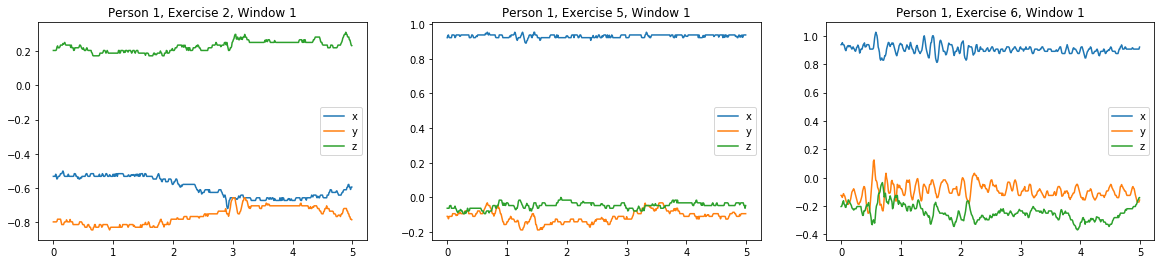

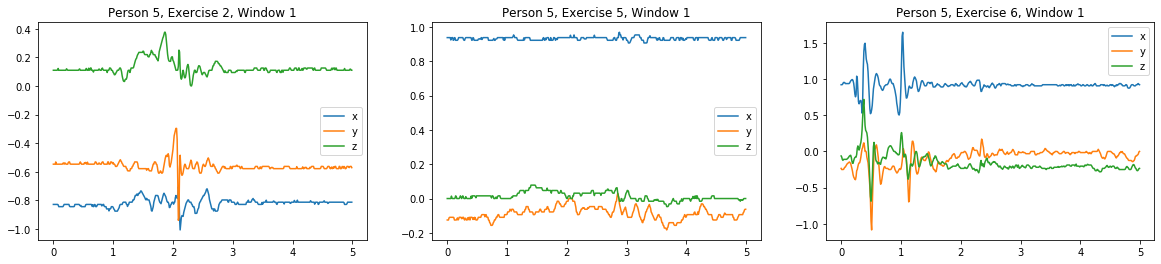

In [5]:
"""
    Plot the first window of acceleration data.
"""
t = np.arange(0, 5, 0.01)
acc_person1_exercise2 = acc_windows(allData[0][0][1].to_numpy())[0]
acc_person1_exercise5 = acc_windows(allData[0][0][6].to_numpy())[0]
acc_person1_exercise6 = acc_windows(allData[0][0][7].to_numpy())[0]
acc_person5_exercise2 = acc_windows(allData[0][4][1].to_numpy())[0]
acc_person5_exercise5 = acc_windows(allData[0][4][6].to_numpy())[0]
acc_person5_exercise6 = acc_windows(allData[0][4][7].to_numpy())[0]

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax1.plot(t, acc_person1_exercise2)
ax1.legend(['x', 'y', 'z'])
ax1.set_title("Person 1, Exercise 2, Window 1")
ax2.plot(t, acc_person1_exercise5)
ax2.legend(['x', 'y', 'z'])
ax2.set_title("Person 1, Exercise 5, Window 1")
ax3.plot(t, acc_person1_exercise6)
ax3.legend(['x', 'y', 'z'])
ax3.set_title("Person 1, Exercise 6, Window 1")

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax1.plot(t, acc_person5_exercise2)
ax1.legend(['x', 'y', 'z'])
ax1.set_title("Person 5, Exercise 2, Window 1")
ax2.plot(t, acc_person5_exercise5)
ax2.legend(['x', 'y', 'z'])
ax2.set_title("Person 5, Exercise 5, Window 1")
ax3.plot(t, acc_person5_exercise6)
ax3.legend(['x', 'y', 'z'])
ax3.set_title("Person 5, Exercise 6, Window 1")

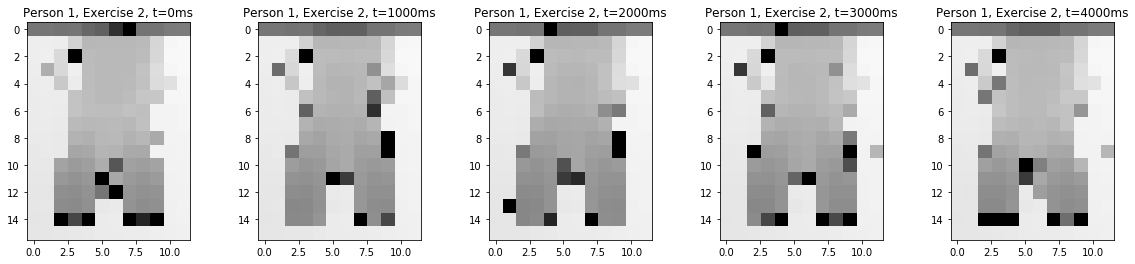

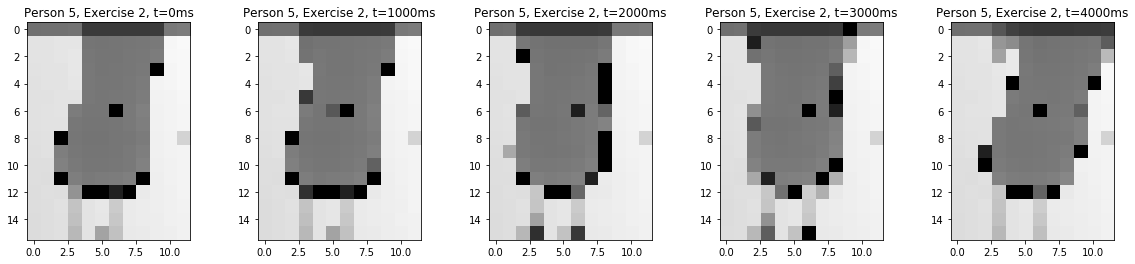

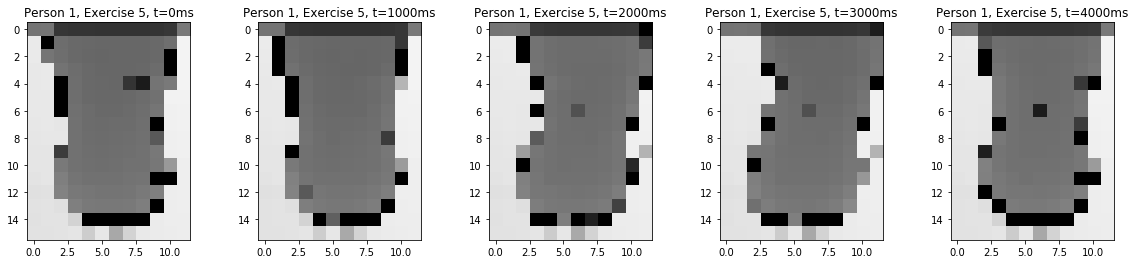

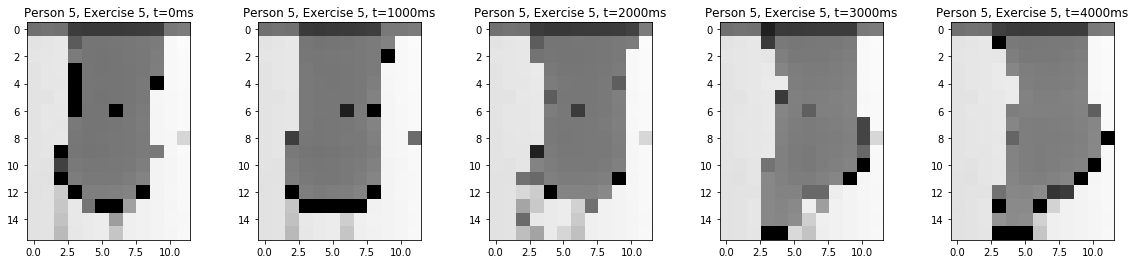

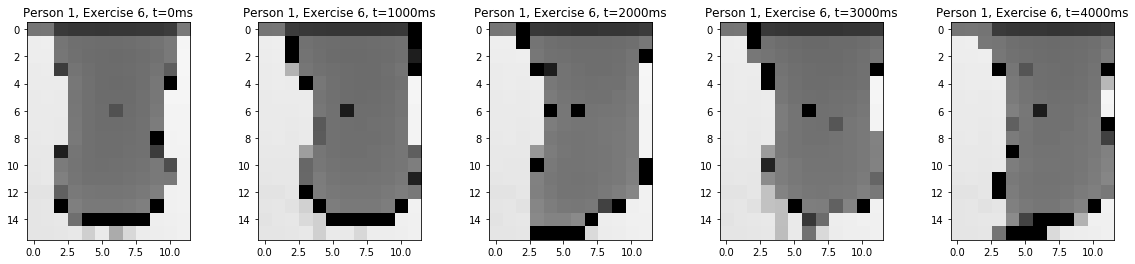

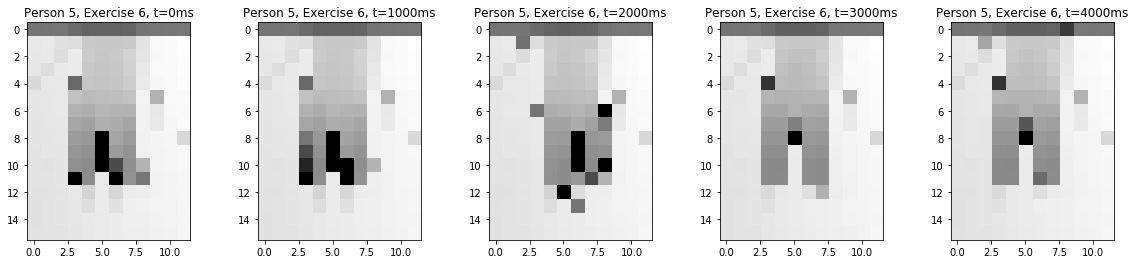

In [6]:
"""
    Plot the first window of depth image data.
"""
depth_person1_exercise2 = depth_windows(allData[1][0][1].to_numpy())[0]
depth_person1_exercise5 = depth_windows(allData[1][0][6].to_numpy())[0]
depth_person1_exercise6 = depth_windows(allData[1][0][7].to_numpy())[0]
depth_person5_exercise2 = depth_windows(allData[1][4][6].to_numpy())[0]
depth_person5_exercise5 = depth_windows(allData[1][4][7].to_numpy())[0]
depth_person5_exercise6 = depth_windows(allData[1][4][1].to_numpy())[0]

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(0, 5):
    axes[i].set_title("Person 1, Exercise 2, t=" + str(i*1000) + "ms")
    axes[i].imshow(depth_person1_exercise2[i].reshape((12, 16)).T, cmap='gray', vmin=0.0, vmax=1.0)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(0, 5):
    axes[i].set_title("Person 5, Exercise 2, t=" + str(i*1000) + "ms")
    axes[i].imshow(depth_person5_exercise2[i].reshape((12, 16)).T, cmap='gray', vmin=0.0, vmax=1.0)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(0, 5):
    axes[i].set_title("Person 1, Exercise 5, t=" + str(i*1000) + "ms")
    axes[i].imshow(depth_person1_exercise5[i].reshape((12, 16)).T, cmap='gray', vmin=0.0, vmax=1.0)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(0, 5):
    axes[i].set_title("Person 5, Exercise 5, t=" + str(i*1000) + "ms")
    axes[i].imshow(depth_person5_exercise5[i].reshape((12, 16)).T, cmap='gray', vmin=0.0, vmax=1.0)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(0, 5):
    axes[i].set_title("Person 1, Exercise 6, t=" + str(i*1000) + "ms")
    axes[i].imshow(depth_person1_exercise6[i].reshape((12, 16)).T, cmap='gray', vmin=0.0, vmax=1.0)
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for i in range(0, 5):
    axes[i].set_title("Person 5, Exercise 6, t=" + str(i*1000) + "ms")
    axes[i].imshow(depth_person5_exercise6[i].reshape((12, 16)).T, cmap='gray', vmin=0.0, vmax=1.0)

## Data preparation

In [7]:
"""
    Split allData to training and test sets.
    Persons 1-7 are used for training and persons 8-10 for testing.
"""

def index_to_exercise_label(index):
    assert(index >= 0 and index <= 7)
    if ((index + 1) < 5): return index + 1
    if ((index + 1) == 5): return 4 
    else: return index

acc_train_data = list(map(lambda index: acc_windows(allData[0][index[0]][index[1]]), np.ndindex(7, 8)))
acc_test_data = list(map(lambda index: acc_windows(allData[0][index[0] + 7][index[1]]), np.ndindex(3, 8)))
depth_train_data = list(map(lambda index: depth_windows(allData[1][index[0]][index[1]]), np.ndindex(7, 8)))
depth_test_data = list(map(lambda index: depth_windows(allData[1][index[0] + 7][index[1]]), np.ndindex(3, 8)))
train_label = list(map(lambda i: np.full(acc_train_data[i[0]].shape[0], index_to_exercise_label(i[1][1])), enumerate(np.ndindex(7, 8))))
test_label = list(map(lambda i: np.full(acc_test_data[i[0]].shape[0], index_to_exercise_label(i[1][1])), enumerate(np.ndindex(3, 8))))

# Remove outlier
acc_train_data[14] = np.delete(acc_train_data[14], 29, axis=0)
train_label[14] = np.delete(train_label[14], 29, axis=0)

# Create LOSO validation indices
person_indices = []
person_idx_count = 0
for i in range(0, 7):
    person_indices.append(person_idx_count)
    for j in range(0, 8):
        person_idx_count += len(train_label[i*8 + j])
person_indices.append(person_idx_count)
valid_train_indices = list(map(lambda i: np.union1d(np.arange(0, person_indices[i], 1), np.arange(person_indices[i+1], person_indices[-1], 1)), [0, 1, 2, 3, 4, 5, 6]))
valid_test_indices = list(map(lambda i: np.arange(person_indices[i], person_indices[i+1], 1), [0, 1, 2, 3, 4, 5, 6]))

# Concatenate train and test data 
acc_train_data = reduce(lambda a, b: np.concatenate([a, b], axis=0), acc_train_data)
acc_test_data = reduce(lambda a, b: np.concatenate([a, b], axis=0), acc_test_data)
depth_train_data = reduce(lambda a, b: np.concatenate([a, b], axis=0), depth_train_data)
depth_test_data = reduce(lambda a, b: np.concatenate([a, b], axis=0), depth_test_data)
train_label = reduce(lambda a, b: np.concatenate([a, b], axis=0), train_label)
test_label = reduce(lambda a, b: np.concatenate([a, b], axis=0), test_label)

In [8]:
"""
    Show dataset statistics.
"""
for x in [["Acceleration training data", acc_train_data], ["Depth image training data", depth_train_data], ["Training labels", train_label], ["Acceleration testing data", acc_test_data], ["Depth image testing data", depth_test_data], ["Testing labels", test_label]]:
    print("---- " + x[0] + " ----")
    print("Shape: \t" + str(x[1].shape))
    print("Min: \t" + str(np.min(x[1])))
    print("Max: \t" + str(np.max(x[1])))
    print()

---- Acceleration training data ----
Shape: 	(1486, 500, 3)
Min: 	-2.3375
Max: 	1.9109369999999999

---- Depth image training data ----
Shape: 	(1486, 5, 192)
Min: 	0.0
Max: 	0.9961

---- Training labels ----
Shape: 	(1486,)
Min: 	1
Max: 	7

---- Acceleration testing data ----
Shape: 	(598, 500, 3)
Min: 	-1.867188
Max: 	1.448437

---- Depth image testing data ----
Shape: 	(598, 5, 192)
Min: 	0.0
Max: 	1.0

---- Testing labels ----
Shape: 	(598,)
Min: 	1
Max: 	7



# 2. Feature extraction and fusion for unimodal classification

<a id='task2'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 2.</b>

Use the training dataset prepared in task 1. to build models based on the combination of principal component analysis (PCA), linear discriminant analysis (LDA), and nearest neighbour (NN) classifier for each modality separately and evaluate the model on test dataset. Do the subtasks given as
<br>
<br>
<p> <b>2.1</b> Calculate PCA and LDA transformations to reduce the dimensionality of accelerometer data (e.g., using scikit-learn implementations). Before transformations downsample data from 100 Hz to 25 Hz (using scipy.signal.resample) to get 125x3 matrix of data for each 5 sec window. You should also standardize the values to zero mean and unit variance before the transformations. Using training dataset, fit PCA with 5-dimensional subspace (i.e., choosing the 5 largest principal components) and fit LDA with 5-dimensional subspace. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 3x(5+5). Perform the fusion of PCA and LDA similar manner as presented in Lecture 3 (pages-19-20) using NN method. Evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br>
<p> <b>2.2</b> Use PCA and LDA transformations to reduce the dimensionality of depth images. You should also standardize the values to zero mean and unit variance before the transformations. Fit PCA and LDA for all training images (12x16, 192-dimensional in vectorized form) by choosing 5-dimensional subspace for both PCA and LDA. Transform both train and test examples to this low-dimensional feature representation. Concatenate each sequence to single vector size of 5x1x(5+5). Similar to task 2.1, do the PCA and LDA fusion using NN and evaluate the performance on testset. Show confusion matrix and F1 scores of the results. </p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 2.1-2.2.
    
</div>

## Methods

In [9]:
def acc_preprocess(acc_data, acc_train_data):
    """
    Preprocesses acceleration data prior to PCA/LDA dimensionality reduction.

    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).

    Returns: 
        [x: Numpy array of shape (_, 125),
         y: Numpy array of shape (_, 125),
         z: Numpy array of shape (_, 125)]
    """
    x = acc_data.T[0].T
    y = acc_data.T[1].T
    z = acc_data.T[2].T
    x = resample(x, num=125, axis=1)
    y = resample(y, num=125, axis=1)
    z = resample(z, num=125, axis=1)
    acc_train_data_x = acc_train_data.T[0].T
    acc_train_data_y = acc_train_data.T[1].T
    acc_train_data_z = acc_train_data.T[2].T
    acc_train_data_x = resample(acc_train_data_x, num=125, axis=1)
    acc_train_data_y = resample(acc_train_data_y, num=125, axis=1)
    acc_train_data_z = resample(acc_train_data_z, num=125, axis=1)
    x = (x - np.mean(acc_train_data_x, axis=0)) / np.std(acc_train_data_x, axis=0)
    y = (y - np.mean(acc_train_data_y, axis=0)) / np.std(acc_train_data_y, axis=0)
    z = (z - np.mean(acc_train_data_z, axis=0)) / np.std(acc_train_data_z, axis=0)
    return [x, y, z]

def acc_pca(acc_data, acc_train_data, n_components):
    """
    Applies PCA dimensionality reduction to acceleration data.

    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        n_components: Number of components for each channel.

    Returns: 
        Numpy array of shape (_,  3 * n_components)
    """
    x, y, z = acc_preprocess(acc_data, acc_train_data)
    tx, ty, tz = acc_preprocess(acc_train_data, acc_train_data)
    pca_x = PCA(n_components=n_components)
    pca_y = PCA(n_components=n_components)
    pca_z = PCA(n_components=n_components)
    pca_x = pca_x.fit(tx)
    pca_y = pca_y.fit(ty)
    pca_z = pca_z.fit(tz)
    return np.concatenate([pca_x.transform(x), pca_y.transform(y), pca_z.transform(z)], axis=1)

def acc_lda(acc_data, acc_train_data, n_components):
    """
    Applies LDA dimensionality reduction to acceleration data.

    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        n_components: Number of components for each channel.

    Returns: 
        Numpy array of shape (_,  3 * n_components)
    """
    x, y, z = acc_preprocess(acc_data, acc_train_data)
    tx, ty, tz = acc_preprocess(acc_train_data, acc_train_data)
    lda_x = LDA(n_components=n_components)
    lda_y = LDA(n_components=n_components)
    lda_z = LDA(n_components=n_components)
    lda_x = lda_x.fit(tx, train_label)
    lda_y = lda_y.fit(ty, train_label)
    lda_z = lda_z.fit(tz, train_label)
    return np.concatenate([lda_x.transform(x), lda_y.transform(y), lda_z.transform(z)], axis=1)

def acc_classify_nn(acc_data, acc_train_data, train_label):
    """
    Classifies exercise type from acceleration data using the NN PCA+LDA method.
    
    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        train_label: Training labels, Numpy array of shape (__)

    Returns: 
        Numpy array of shape (_) containing the predicted labels.
    """
    result = np.zeros(acc_data.shape[0])
    a_pca = acc_pca(acc_data, acc_train_data, 5)
    a_lda = acc_lda(acc_data, acc_train_data, 5)
    B_pca = acc_pca(acc_train_data, acc_train_data, 5)
    B_lda = acc_lda(acc_train_data, acc_train_data, 5)
    for i in range(0, acc_data.shape[0]):
        d_pca = np.sum(np.square(B_pca - a_pca[i]), axis=1)
        d_lda = np.sum(np.square(B_lda - a_lda[i]), axis=1)
        d_pca = (d_pca - np.min(d_pca)) / (np.max(d_pca) - np.min(d_pca)) 
        d_lda = (d_lda - np.min(d_lda)) / (np.max(d_lda) - np.min(d_lda)) 
        d = 0.5 * (d_pca + d_lda)
        result[i] = train_label[np.argmin(d)]
    return result

In [10]:
def depth_preprocess(depth_data, depth_train_data):
    """
    Preprocesses depth image data prior to PCA/LDA dimensionality reduction.

    Args:
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192)

    Returns: 
        Numpy array of shape (_, 5, 192) containing rescaled data.
    """
    mean = np.mean(depth_train_data, axis=0)
    std = np.std(depth_train_data, axis=0)
    return (depth_data - mean) / std

def depth_pca(depth_data, depth_train_data, n_components):
    """
    Applies PCA dimensionality reduction to depth image data.

    Args:
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192)
        n_components: Number of components for each channel.

    Returns: 
        Numpy array of shape (_, 5, n_components)
    """
    assert(depth_data.shape[1] == 5 and depth_data.shape[2] == 192)
    assert(depth_train_data.shape[1] == 5 and depth_train_data.shape[2] == 192)
    dd = depth_preprocess(depth_data, depth_train_data)
    dd_t = depth_preprocess(depth_train_data, depth_train_data)
    pcas = [PCA(n_components=n_components) for i in range(5)]
    result = []
    for i in range(0, 5): 
        pcas[i].fit(dd_t[:,i,:])
        result.append(pcas[i].transform(dd[:,i,:]))
    return np.concatenate(result, axis=1)

def depth_lda(depth_data, depth_train_data, n_components):
    """
    Applies LDA dimensionality reduction to depth image data.

    Args:
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192)
        n_components: Number of components for each channel.

    Returns: 
        Numpy array of shape (_, 5, n_components)
    """
    assert(depth_data.shape[1] == 5 and depth_data.shape[2] == 192)
    assert(depth_train_data.shape[1] == 5 and depth_train_data.shape[2] == 192)
    dd_c = depth_preprocess(depth_data, depth_train_data)
    dd_t = depth_preprocess(depth_train_data, depth_train_data)
    ldas = [LDA(n_components=n_components) for i in range(5)]
    result = []
    for i in range(0, 5): 
        ldas[i].fit(dd_t[:,i,:], train_label)
        result.append(ldas[i].transform(dd_c[:,i,:]))
    result = np.concatenate(result, axis=1)
    return result

def depth_classify_nn(depth_data, depth_train_data, train_label):
    """
    Classifies exercise type from depth image data using the NN PCA+LDA method.
    
    Args:
        depth_test_data: Input data, Numpy array of shape (_, 5, 192).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192)
        train_label: Training labels, Numpy array of shape (__)

    Returns: 
        Numpy array of shape (_) containing the predicted labels.
    """
    result = np.zeros(depth_data.shape[0])
    a_pca = depth_pca(depth_data, depth_train_data, n_components=5)
    a_lda = depth_lda(depth_data, depth_train_data, n_components=5)
    B_pca = depth_pca(depth_train_data, depth_train_data, n_components=5)
    B_lda = depth_lda(depth_train_data, depth_train_data, n_components=5)
    for i in range(0, depth_test_data.shape[0]):
        d_pca = np.sum(np.square(B_pca - a_pca[i]), axis=1)
        d_lda = np.sum(np.square(B_lda - a_lda[i]), axis=1)
        d_pca = (d_pca - np.min(d_pca)) / (np.max(d_pca) - np.min(d_pca)) 
        d_lda = (d_lda - np.min(d_lda)) / (np.max(d_lda) - np.min(d_lda)) 
        d = 0.5 * (d_pca + d_lda)
        result[i] = train_label[np.argmin(d)]
    return result

## Evaluation

In [11]:
"""
    Evaluate the performance of "acc_classify_nn"
"""
acc_pred_label = acc_classify_nn(acc_test_data, acc_train_data, train_label)
print("---- F1 Macro Score ----")
print(f1_score(test_label, acc_pred_label, average="macro"))
print()
print("---- Confusion Matrix ----")
print(confusion_matrix(test_label, acc_pred_label))

---- F1 Macro Score ----
0.46161318020053904

---- Confusion Matrix ----
[[ 9 13 33  0  5 25  0]
 [ 1 29 11  0 14 23  6]
 [ 0 30 22  0  5 21  8]
 [ 1  1  0 69  9  0  0]
 [ 0 27  3  0 60  0  0]
 [ 0 23  3  0  0 60  2]
 [ 0 15  4  0  2 34 30]]


In [12]:
"""
    Evaluate performance of "depth_classify_nn"
"""
depth_pred_label = depth_classify_nn(depth_test_data, depth_train_data, train_label)
print("---- F1 Macro Score ----")
print(f1_score(test_label, depth_pred_label, average="macro"))
print()
print("---- Confusion Matrix ----")
print(confusion_matrix(test_label, depth_pred_label))

---- F1 Macro Score ----
0.5194407172778946

---- Confusion Matrix ----
[[85  0  0  0  0  0  0]
 [17 53 14  0  0  0  0]
 [40 45  1  0  0  0  0]
 [40 19  0 21  0  0  0]
 [24  0  0  0 66  0  0]
 [ 0  0  0  0  0 31 57]
 [ 1  0  0  1  0  1 82]]


## Key results 

The F1 macro score of Acceleration + PCA/LDA was 0.46 and the score of Depth images + PCA/LDA was 0.52.
There are some notable differences between confusion matrices, for example the former method has high recall and low precision for exercise type 1 while the latter has low recall and high precision for exercise type 1.

# 3. Feature extraction and feature-level fusion for multimodal classification

<a id='task3'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 3.</b>

Prepare new feature sets for each modality and combine them to single feature representation. Compare two classifiers from scikit-learn. Train classifiers using joint feature presentation. Evaluate and compare the result using testing dataset. Do the subtasks given as
<br>   
<br> 
<p> <b>3.1</b> Similar to task 2.1, calculate PCA for accelerometer, but choose now the 10 largest principal components as 10-dim feature vector for each window. In addition, for each window calculate mean and standard deviation of each three acc channels as statistical features, resulting 6-dimensional vector. Combine these to 36-dimensional final feature vector.</p>
<br>  
<p> <b>3.2</b> Similar to task 2.2, calculate the PCA for depth images using same setup, but now choose the 10 largest principal components as feature vector. Concatenate the image sequence forming 50-dimensional feature vector from each windowed example.</p>
<br> 
<p> <b>3.3</b> Form a joint feature presentation of features extracted in 3.1 and 3.2, resulting 86-dimensional feature vector for each example. Normalize data between 0-1 using the training dataset. Use support vector machine (SVM) with RBF-kernel and Gaussian naiveBayes classifier (use default parameter values for both classifiers). Train the classifiers and evaluate and compare classifiers on testset using confusion matrices and F1 scores.</p>
<br> 
Document your work, evaluate the results, and analyse the outcomes in each subtasks 3.1-3.3.
    
</div>

## Methods

In [13]:
def acc_depth_fuse(acc_data, depth_data, acc_train_data, depth_train_data):
    """
    Fuses acceleration and depth image data into joint feature presentation.
    
    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192).

    Returns: 
        Numpy array of shape (_, 86) containing the joint feature presentation.
    """
    result = np.zeros(acc_data.shape[0])
    a = acc_pca(acc_data, acc_train_data, 10)
    a_mean = np.mean(acc_data, axis=1)
    a_std = np.std(acc_data, axis=1)
    d = depth_pca(depth_data, depth_train_data, 10)
    f = np.concatenate([a, a_mean, a_std, d], axis=1)
    return f

def fuse_classify_svm(acc_data, depth_data, acc_train_data, depth_train_data, train_label):
    """
    Classifies exercise type from joint feature presentation using the SVM classifier.
    
    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192).
        train_label: Training labels, Numpy array of shape (__)

    Returns: 
        Numpy array of shape (_) containing the predicted labels.
    """
    f_train = acc_depth_fuse(acc_train_data, depth_train_data, acc_train_data, depth_train_data)
    f_test = acc_depth_fuse(acc_data, depth_data, acc_train_data, depth_train_data)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    svm = SVC(kernel="rbf")
    svm.fit((f_train - f_min) / (f_max - f_min), train_label)
    return svm.predict((f_test - f_min) / (f_max - f_min))
    
def fuse_classify_gnb(acc_data, depth_data, acc_train_data, depth_train_data, train_label):
    """
    Classifies exercise type from  joint feature presentation using the gaussian naive Bayes classifier.
    
    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192).
        train_label: Training labels, Numpy array of shape (__)

    Returns: 
        Numpy array of shape (_) containing the predicted labels.
    """
    f_train = acc_depth_fuse(acc_train_data, depth_train_data, acc_train_data, depth_train_data)
    f_test = acc_depth_fuse(acc_data, depth_data, acc_train_data, depth_train_data)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    gnb = GaussianNB()
    gnb.fit((f_train - f_min) / (f_max - f_min), train_label)
    return gnb.predict((f_test - f_min) / (f_max - f_min))

## Evaluation

In [14]:
"""
    Evaluate the performance of "fuse_classify_svm"
"""
pred_label = fuse_classify_svm(acc_test_data, depth_test_data, acc_train_data, depth_train_data, train_label)
print("---- F1 Macro Score ----")
print(f1_score(test_label, pred_label, average="macro"))
print()
print("---- Confusion Matrix ----")
print(confusion_matrix(test_label, pred_label))

---- F1 Macro Score ----
0.6575795568339576

---- Confusion Matrix ----
[[85  0  0  0  0  0  0]
 [25 56  0  0  0  0  3]
 [ 4 25 37  5  0  0 15]
 [19  0  0 61  0  0  0]
 [28  0  0  0 62  0  0]
 [ 0  0  0  0  0 17 71]
 [ 0  0  0  0  0  0 85]]


In [15]:
"""
    Evaluate the performance of "fuse_classify_gnb"
"""
pred_label = fuse_classify_gnb(acc_test_data, depth_test_data, acc_train_data, depth_train_data, train_label)
print("---- F1 Macro Score ----")
print(f1_score(test_label, pred_label, average="macro")) 
print()
print("---- Confusion Matrix ----")
print(confusion_matrix(test_label, pred_label))

---- F1 Macro Score ----
0.5950536320511254

---- Confusion Matrix ----
[[85  0  0  0  0  0  0]
 [55  4  0  0  0  0 25]
 [12  5 47  0  0 22  0]
 [34  1  0 37  8  0  0]
 [22  0  0  0 35  0 33]
 [ 0  0  0  0  0 88  0]
 [ 0  0  0  0  0  0 85]]


## Key results

The F1 macro score of Joint features + SVM was 0.66 and the score of Joint features + Gaussian Naive Bayes (GNB) was 0.59. Both methods have low precision for exercise type 1. Both methods show an improvement compared to the previous task, highlighting the advantage of feature-level fusion. 

# 4. Decision-level fusion for multimodal classification

<a id='task4'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 4.</b>

Use features calculated for each modality in task 3. Choose base classifier for each modality from scikit-learn. Train classifiers for each modality feature presentations separately and combine the outputs in decision level. Evaluate and compare the result on testing dataset. Do the subtasks given as
<br>
<br> 
<p> <b>4.1</b> Use base classifiers of support vector machine (SVM) with RBF-kernel and AdaBoost classifier (with random_state=0). 
Normalize data between 0-1 using the training dataset. Train the base classifiers by tuning the model parameters (<i>C</i> parameter and RBF-kernel <i>gamma</i> in SVM as well as <i>n_estimators</i> and <i>learning_rate</i> in Adaboost) using 10-fold cross-validation on training dataset to find optimal set of parameters (hint: use GridSearchCV from scikit-learn). For grid search use the following values $C = [0.1, 1.0, 10.0, 100.0]$, $gamma=[0.1, 0.25, 0.5, 0.75, 1.0, 2.0]$, $n\_estimators = [50, 100, 500, 1000]$, and $learning\_rate = [0.1, 0.25, 0.5, 0.75,1.0]$. Choose the best parameters and train the classifiers for each modality on whole training dataset. Is there a possibility that classifiers will overfit to training data using this parameter selection strategy? If so, why? </p>
<br>
<p> <b>4.2</b> Predict probabilistic outputs of each trained classifier for both modalities using the test set. </p>
<br>
<p> <b>4.3</b> Combine the probabilistic outputs of different modalities by fixed classification rules: max, min, prod, and sum. Evaluate, compare, and analyse the final combined results using confusion matrices and F1 scores. Show results for each base classifier combinations (i.e., $SVM_{acc}+SVM_{depth}$, $AdaBoost_{acc}+AdaBoost_{depth}$, $SVM_{acc}+AdaBoost_{depth}$, $AdaBoost_{acc}+SVM_{depth}$)</p>
<br>
Document your work, evaluate the results, and analyse the outcomes in each subtasks 4.1-4.3.
    
</div>

## Methods

In [16]:
def acc_classify_svm(acc_data, acc_train_data, train_label, C, gamma):
    """
    Classifies acceleration data using the PCA -> SVM method.
    
    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        train_label: Training labels, Numpy array of shape (__).
        C: Regularization parameter for SVM.
        gamma: Kernel coefficient for SVM.
        
    Returns: 
        Numpy array of shape (_, 7 or 10) containing predicted probability vectors.
    """
    acc_train_pca = acc_pca(acc_train_data, acc_train_data, 10)
    acc_train_mean = np.mean(acc_train_data, axis=1)
    acc_train_std = np.std(acc_train_data, axis=1)
    f_train = np.concatenate([acc_train_pca, acc_train_mean, acc_train_std], axis=1)
    acc_data_pca = acc_pca(acc_data, acc_train_data, 10)
    acc_data_mean = np.mean(acc_data, axis=1)
    acc_data_std = np.std(acc_data, axis=1)
    f_test = np.concatenate([acc_data_pca, acc_data_mean, acc_data_std], axis=1)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    svm = SVC(kernel="rbf", C=C, gamma=gamma, probability=True, random_state=0)
    svm.fit((f_train - f_min) / (f_max - f_min), train_label)
    return svm.predict_proba((f_test - f_min) / (f_max - f_min))

def acc_classify_adaboost(acc_data, acc_train_data, train_label, n_estimators, learning_rate):
    """
    Classifies acceleration data using the PCA -> Adaboost method.
    
    Args:
        acc_data: Numpy array of shape (_, 500, 3).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        train_label: Training labels, Numpy array of shape (__).
        n_estimators: Num estimators for Adaboost.
        learning_rate: Learning rate for Adaboost.
        
    Returns: 
        Numpy array of shape (_, 7 or 10) containing predicted probability vectors.
    """
    acc_train_pca = acc_pca(acc_train_data, acc_train_data, 10)
    acc_train_mean = np.mean(acc_train_data, axis=1)
    acc_train_std = np.std(acc_train_data, axis=1)
    f_train = np.concatenate([acc_train_pca, acc_train_mean, acc_train_std], axis=1)
    acc_data_pca = acc_pca(acc_data, acc_train_data, 10)
    acc_data_mean = np.mean(acc_data, axis=1)
    acc_data_std = np.std(acc_data, axis=1)
    f_test = np.concatenate([acc_data_pca, acc_data_mean, acc_data_std], axis=1)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    abc = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    abc.fit((f_train - f_min) / (f_max - f_min), train_label)
    return abc.predict_proba((f_test - f_min) / (f_max - f_min))

def depth_classify_svm(depth_data, depth_train_data, train_label, C, gamma):
    """
    Classifies depth image data using the PCA -> SVM method.
    
    Args:
        depth_data: Inpt data, Numpy array of shape (_, 5, 192).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192).
        train_label: Training labels, Numpy array of shape (__).
        C: Regularization parameter for SVM.
        gamma: Kernel coefficient for SVM.
        
    Returns: 
        Numpy array of shape (_, 7 or 10) containing predicted probability vectors.
    """
    f_train = depth_pca(depth_train_data, depth_train_data, 10)
    f_test = depth_pca(depth_data, depth_train_data, 10)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    svm = SVC(kernel="rbf", C=C, gamma=gamma, probability=True, random_state=0)
    svm.fit((f_train - f_min) / (f_max - f_min), train_label)
    return svm.predict_proba((f_test - f_min) / (f_max - f_min))
    
def depth_classify_adaboost(depth_data, depth_train_data, train_label, n_estimators, learning_rate):
    """
    Classifies depth image data using the PCA -> Adaboost method.
    
    Args:
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192).
        train_label: Training labels, Numpy array of shape (__).
        n_estimators: Num estimators for Adaboost.
        learning_rate: Learning rate for Adaboost.
        
    Returns: 
        Numpy array of shape (_, 7 or 10) containing predicted probability vectors.
    """
    f_train = depth_pca(depth_train_data, depth_train_data, 10)
    f_test = depth_pca(depth_data, depth_train_data, 10)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    abc = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=0)
    abc.fit((f_train - f_min) / (f_max - f_min), train_label)
    return abc.predict_proba((f_test - f_min) / (f_max - f_min))

In [17]:
def find_parameters_acc_svm(acc_train_data, train_label):
    """
    Finds optimal set of hyperparameters for the method "acc_classify_svm".
    
    Args:
        acc_train_data: Training data, Numpy array of shape (_, 500, 3).
        train_label: Training labels, Numpy array of shape (_)
        
    Returns: 
        { 'C': <optimal value for C>, 'gamma': <optimal value for gamma> }
    """
    parameters = {'C':[0.1, 1, 10, 100], 'gamma': [0.1, 0.25, 0.5, 0.75, 1, 2]}
    acc_train_pca = acc_pca(acc_train_data, acc_train_data, 10)
    acc_train_mean = np.mean(acc_train_data, axis=1)
    acc_train_std = np.std(acc_train_data, axis=1)
    f_train = np.concatenate([acc_train_pca, acc_train_mean, acc_train_std], axis=1)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    svm = SVC(kernel="rbf", probability=True, random_state=0)
    #gscv = GridSearchCV(svm, parameters, cv=zip(valid_train_indices, valid_test_indices))
    gscv = GridSearchCV(svm, parameters, cv=10)
    gscv.fit((f_train - f_min) / (f_max - f_min), train_label)
    return gscv.best_params_

def find_parameters_acc_adaboost(acc_train_data, train_label):
    """
    Finds optimal set of hyperparameters for the method "acc_classify_adaboost".
    
    Args:
        acc_train_data: Training data, Numpy array of shape (_, 500, 3).
        train_label: Training labels, Numpy array of shape (_)
        
    Returns: 
        { 'n_estimators': <optimal value for n_estimators>, 'learning_rate': <optimal value for learning_rate> }
    """
    parameters = {'n_estimators':[50, 100, 50, 1000], 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]}
    acc_train_pca = acc_pca(acc_train_data, acc_train_data, 10)
    acc_train_mean = np.mean(acc_train_data, axis=1)
    acc_train_std = np.std(acc_train_data, axis=1)
    f_train = np.concatenate([acc_train_pca, acc_train_mean, acc_train_std], axis=1)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    abc = AdaBoostClassifier(random_state=0)
    #gscv = GridSearchCV(abc, parameters, cv=zip(valid_train_indices, valid_test_indices))
    gscv = GridSearchCV(abc, parameters, cv=10)
    gscv.fit((f_train - f_min) / (f_max - f_min), train_label)
    return gscv.best_params_

def find_parameters_depth_svm(depth_train_data, train_label):
    """
    Finds optimal set of hyperparameters for the method "depth_classify_svm".
            
    Args:
        depth_train_data: Training data, Numpy array of shape (_, 5, 192).
        train_label: Training labels, Numpy array of shape (_)
                
    Returns: 
        { 'C': <optimal value for C>, 'gamma': <optimal value for gamma> }
    """
    parameters = {'C':[0.1, 1, 10, 100], 'gamma': [0.1, 0.25, 0.5, 0.75, 1, 2]}
    f_train = depth_pca(depth_train_data, depth_train_data, 10)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    svm = SVC(kernel="rbf", probability=True, random_state=0)
    #gscv = GridSearchCV(svm, parameters, cv=zip(valid_train_indices, valid_test_indices))
    gscv = GridSearchCV(svm, parameters, cv=10)
    gscv.fit((f_train - f_min) / (f_max - f_min), train_label)
    return gscv.best_params_

def find_parameters_depth_adaboost(depth_train_data, train_label):
    """
    Finds optimal set of hyperparameters for the method "depth_classify_adaboost".
    
    Args:
        depth_train_data: Training data, Numpy array of shape (_, 5, 192).
        train_label: Training labels, Numpy array of shape (_)
        
    Returns: 
        { 'n_estimators': <optimal value for n_estimators>, 'learning_rate': <optimal value for learning_rate> }
    """
    parameters = {'n_estimators':[50, 100, 50, 1000], 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1.0]}
    f_train = depth_pca(depth_train_data, depth_train_data, 10)
    f_min = np.min(f_train, axis=0)
    f_max = np.max(f_train, axis=0)
    abc = AdaBoostClassifier(random_state=0)
    #gscv = GridSearchCV(abc, parameters, cv=zip(valid_train_indices, valid_test_indices))
    gscv = GridSearchCV(abc, parameters, cv=10)
    gscv.fit((f_train - f_min) / (f_max - f_min), train_label)
    return gscv.best_params_

## Evaluation

In [18]:
"""
    Find optimal set of parameters.
"""
#print(find_parameters_acc_svm(acc_train_data, train_label))          # {'C': 100, 'gamma': 1}
#print(find_parameters_acc_adaboost(acc_train_data, train_label))     # {'n_estimators': 1000, 'learning_rate': 0.75}
#print(find_parameters_depth_svm(depth_train_data, train_label))      # {'C': 100, 'gamma': 0.25}
#print(find_parameters_depth_adaboost(depth_train_data, train_label)) # {'n_estimators': 1000, 'learning_rate': 0.5}

'\n    Find optimal set of parameters.\n'

In [19]:
""" 
    Predict probabilistic outputs.
"""
pred_proba_acc_svm = acc_classify_svm(acc_test_data, acc_train_data, train_label, 100.0, 1.0)
pred_proba_acc_abc = acc_classify_adaboost(acc_test_data, acc_train_data, train_label, 1000, 0.75)
pred_proba_depth_svm = depth_classify_svm(depth_test_data, depth_train_data, train_label, 100.0, 0.25)
pred_proba_depth_abc = depth_classify_adaboost(depth_test_data, depth_train_data, train_label, 1000, 0.5)

In [20]:
def combine_predictions(pred_proba1, pred_proba2, gt_labels):
    """
    Combines two probabilistic outputs using max, min, prod and sum methods,
    then prints the f1_score and confusion matrix.
    
    Args:
        pred_proba1: Probability vector of shape (_, 7 or 10)
        pred_proba2: Probability vector of shape (_, 7 or 10)
        gt_labels: Ground truth integer labels of shape (_)
    """
    max_vote = 1 + np.argmax(np.max(np.stack([pred_proba1, pred_proba2], axis=1), axis=1), axis=1)
    min_vote = 1 + np.argmax(np.min(np.stack([pred_proba1, pred_proba2], axis=1), axis=1), axis=1)
    prod_vote = 1 + np.argmax(np.prod(np.stack([pred_proba1, pred_proba2], axis=1), axis=1), axis=1)
    sum_vote = 1 + np.argmax(np.sum(np.stack([pred_proba1, pred_proba2], axis=1), axis=1), axis=1)
    print("---- F1 Macro Score (Max Vote) ----")
    print(f1_score(gt_labels, max_vote, average="macro")) 
    print()
    print("---- F1 Macro Score (Min Vote) ----")
    print(f1_score(gt_labels, min_vote, average="macro"))
    print()
    print("---- F1 Macro Score (Prod Vote) ----")
    print(f1_score(gt_labels, prod_vote, average="macro")) 
    print()
    print("---- F1 Macro Score (Sum Vote) ----")
    print(f1_score(gt_labels, sum_vote, average="macro")) 
    print()
    print("---- Confusion Matrix (Max Vote) ----")
    print(confusion_matrix(gt_labels, max_vote)) 
    print()
    print("---- Confusion Matrix (Min Vote) ----")
    print(confusion_matrix(gt_labels, min_vote)) 
    print()
    print("---- Confusion Matrix (Prod Vote) ----")
    print(confusion_matrix(gt_labels, prod_vote)) 
    print()
    print("---- Confusion Matrix (Sum Vote) ----")
    print(confusion_matrix(gt_labels, sum_vote)) 
    print()

In [21]:
"""
    Print the scores of SVM_acc + SVM_depth
"""
combine_predictions(pred_proba_acc_svm, pred_proba_depth_svm, test_label)

---- F1 Macro Score (Max Vote) ----
0.5236287236197941

---- F1 Macro Score (Min Vote) ----
0.5780716898721738

---- F1 Macro Score (Prod Vote) ----
0.5558664998270636

---- F1 Macro Score (Sum Vote) ----
0.5426035725008401

---- Confusion Matrix (Max Vote) ----
[[58  0  0  0  0  0 27]
 [ 2 72  0  0  1  9  0]
 [14 36  5  0  2 29  0]
 [65  0  0 15  0  0  0]
 [12 22  0  1 52  0  3]
 [ 0  4  0  0  0 58 26]
 [ 0  0  0  0  0  1 84]]

---- Confusion Matrix (Min Vote) ----
[[69  0  0  0  0  0 16]
 [ 5 51  0  0  0  1 27]
 [ 2 44 11  0  0  0 29]
 [60  0  0 18  0  0  2]
 [ 4  2  0  0 81  0  3]
 [ 0 25  0  0  0 52 11]
 [ 0  0  0  0  0  0 85]]

---- Confusion Matrix (Prod Vote) ----
[[65  0  0  0  0  0 20]
 [ 3 57  0  0  0 24  0]
 [ 5 45  7  0  0 29  0]
 [60  0  0 20  0  0  0]
 [ 3 13  0  1 70  0  3]
 [ 0 16  0  0  0 54 18]
 [ 0  0  0  0  0  1 84]]

---- Confusion Matrix (Sum Vote) ----
[[58  0  0  0  0  0 27]
 [ 2 73  0  0  0  9  0]
 [12 39  6  0  0 29  0]
 [64  0  0 16  0  0  0]
 [ 5 21  0  1 59

In [22]:
"""
    Print the scores of Adaboost_acc + Adaboost_depth
""" 
combine_predictions(pred_proba_acc_abc, pred_proba_depth_abc, test_label)

---- F1 Macro Score (Max Vote) ----
0.4568267095436025

---- F1 Macro Score (Min Vote) ----
0.684441768151723

---- F1 Macro Score (Prod Vote) ----
0.678543036881096

---- F1 Macro Score (Sum Vote) ----
0.6517130162093823

---- Confusion Matrix (Max Vote) ----
[[85  0  0  0  0  0  0]
 [66  6  0  0  0  0 12]
 [85  1  0  0  0  0  0]
 [26  0  0 32 21  0  1]
 [33  0  0  0 53  0  4]
 [ 0  0  0  0  0 55 33]
 [ 0  0  0  0  0 13 72]]

---- Confusion Matrix (Min Vote) ----
[[85  0  0  0  0  0  0]
 [11 73  0  0  0  0  0]
 [ 0 86  0  0  0  0  0]
 [14  0  0 66  0  0  0]
 [ 0 29  0  0 61  0  0]
 [ 0  0  0  0  0 61 27]
 [ 0  0  0  0  0  1 84]]

---- Confusion Matrix (Prod Vote) ----
[[85  0  0  0  0  0  0]
 [11 73  0  0  0  0  0]
 [ 0 86  0  0  0  0  0]
 [14  0  0 66  0  0  0]
 [ 0 28  0  0 62  0  0]
 [ 0  0  0  0  0 56 32]
 [ 0  0  0  0  0  0 85]]

---- Confusion Matrix (Sum Vote) ----
[[85  0  0  0  0  0  0]
 [13 64  0  0  0  0  7]
 [ 6 80  0  0  0  0  0]
 [14  0  0 66  0  0  0]
 [30  0  0  0 59  

In [23]:
"""
    Print the scores of SVM_acc + Adaboost_depth
""" 
combine_predictions(pred_proba_acc_svm, pred_proba_depth_abc, test_label)

---- F1 Macro Score (Max Vote) ----
0.5915644857995529

---- F1 Macro Score (Min Vote) ----
0.7032240752991105

---- F1 Macro Score (Prod Vote) ----
0.7167051238992714

---- F1 Macro Score (Sum Vote) ----
0.6254202551189965

---- Confusion Matrix (Max Vote) ----
[[57  0  0  0  0  0 28]
 [ 1 42  0  0 12 29  0]
 [ 9 41  0  0  7 29  0]
 [ 7  0  0 73  0  0  0]
 [ 6 23  0  0 59  0  2]
 [ 0 18  0  0  0 69  1]
 [ 0  0  0  0  0 11 74]]

---- Confusion Matrix (Min Vote) ----
[[85  0  0  0  0  0  0]
 [ 9 57  0 10  2  0  6]
 [ 0 57  0 18 11  0  0]
 [ 5  0  0 75  0  0  0]
 [ 0 30  0  0 60  0  0]
 [ 0  0  0  0  0 88  0]
 [ 0  0  0  0  0  2 83]]

---- Confusion Matrix (Prod Vote) ----
[[85  0  0  0  0  0  0]
 [19 56  0  2  0  7  0]
 [ 6 57  0 23  0  0  0]
 [ 7  0  0 73  0  0  0]
 [ 0 16  0  0 73  0  1]
 [ 0  0  0  0  0 88  0]
 [ 0  0  0  0  0  2 83]]

---- Confusion Matrix (Sum Vote) ----
[[57  0  0  0  0  0 28]
 [ 2 45  0  0  8 29  0]
 [ 4 48  1  0  4 29  0]
 [ 7  0  0 73  0  0  0]
 [ 1 23  0  0 64

In [24]:
"""
    Print the scores of Adaboost_acc + SVM_depth
""" 
combine_predictions(pred_proba_acc_abc, pred_proba_depth_svm, test_label)

---- F1 Macro Score (Max Vote) ----
0.46357410892069206

---- F1 Macro Score (Min Vote) ----
0.6184567813193482

---- F1 Macro Score (Prod Vote) ----
0.692676534113347

---- F1 Macro Score (Sum Vote) ----
0.5118522587014609

---- Confusion Matrix (Max Vote) ----
[[85  0  0  0  0  0  0]
 [25 58  0  0  0  0  1]
 [29 35 22  0  0  0  0]
 [80  0  0  0  0  0  0]
 [34  0  0  2 32  0 22]
 [ 0  0  0  0  0 28 60]
 [ 0  0  0  0  0  0 85]]

---- Confusion Matrix (Min Vote) ----
[[84  0  0  0  0  0  1]
 [ 7 66 11  0  0  0  0]
 [ 0 46 40  0  0  0  0]
 [28  0  6  8  0  4 34]
 [ 0  0  0  0 86  0  4]
 [ 0  0  0  0  0 29 59]
 [ 0  0  0  0  0  0 85]]

---- Confusion Matrix (Prod Vote) ----
[[85  0  0  0  0  0  0]
 [ 5 79  0  0  0  0  0]
 [ 0 46 40  0  0  0  0]
 [28  0  0 28  3  0 21]
 [ 0  0  0  0 85  0  5]
 [ 0  0  0  0  0 28 60]
 [ 0  0  0  0  0  0 85]]

---- Confusion Matrix (Sum Vote) ----
[[85  0  0  0  0  0  0]
 [23 60  0  0  0  0  1]
 [21 37 28  0  0  0  0]
 [80  0  0  0  0  0  0]
 [29  0  0  1 50

## Key results

Using the cross validated grid search method, the "optimal" parameters were found to be 
- $SVM_\text{acc}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $C = 100$ and $\gamma = 1$
- $AdaBoost_\text{acc}$ &nbsp;&nbsp;&nbsp;&nbsp; $\text{n_estimators} = 1000$ and $\text{learning_rate} = 0.75$
- $SVM_\text{depth}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $C = 100$ and $\gamma = 0.25$
- $AdaBoost_\text{depth}$ &nbsp; $\text{n_estimators} = 1000$ and $\text{learning_rate} = 0.5$

The default cross validation in GridSearchCV may overfit to training data because the data is temporally dependent (the windows have overlap of 3 seconds). If the dependency exists between training and test data it may cause overfitting. An alternative LOSO validation split is provided in the code (commented).

Out of all decision strategies, the highest F1-score was obtained by using SVM for acceleration data, Adaboost for depth data and by using product-vote strategy, resulting in a F1-score of 0.72. Compared to feature-level fusion in the previous exercise, the F1-score is higher, highlighting that decision-level fusion can be more effective than feature-level. 


<table>
<tr>
    <td><b>Base classifiers / Classification rule</b></td>
    <td>Max</td>
    <td>Min</td> 
    <td>Prod</td> 
    <td>Sum</td> 
</tr>

<tr>
    <td>SVM Acc. and SVM Depth</td> 
    <td>0.52</td> 
    <td>0.57</td>
    <td>0.55</td>
    <td>0.54</td>
</tr>

<tr>
    <td>Adaboost Acc. and Adaboost Depth</td> 
    <td>0.44</td> 
    <td>0.65</td>
    <td>0.65</td>
    <td>0.63</td>
</tr>
    
<tr>
    <td>SVM Acc. and Adaboost Depth</td> 
    <td>0.60</td> 
    <td>0.71</td>
    <td>0.72</td>
    <td>0.63</td> 
</tr>

<tr>
    <td>Adaboost Acc. and SVM Depth</td> 
    <td>0.45</td> 
    <td>0.61</td>
    <td>0.69</td>
    <td>0.52</td>   
</tr>
    
</table>

# 5. Bonus task: Multimodal biometric identification of persons (optional)

<a id='task5'></a>
<div class=" alert alert-warning">
    <b>Assigment.</b> <b>Task 5.</b>

Can you build a classifier that recognizes the person who is performing the exercise? Use same 10 person dataset and split it so that first 25% of each long exercise sequence is used for training and rest 75% of each sequence is used for testing the classifier. Use same 5 second windowing with 3 seconds overlap to prepare the examples. Note that, now the person identity is the class label instead of exercise type. Max. 10 points are given but you can earn points from partial solution, as well.
<br> 
<br> 
<p> <b>5.1</b> Build a classifier to identify persons based on the features and one of the models given in task 4 (max. 5 points).</p>
<br> 
<p> <b>5.2</b> Can you build your own solution (using new features, new classification model or different fusion approaches) to beat the approach in Task 5.1 ? (max. 5 points) </p>
<br>  
Document your work. Evaluate and compare the results using confusion matrix and F1 score.

</div>

## Data preparation

In [25]:
"""
    Split allData to training and test sets.
    25% of each sequence is used for training and 75% for testing.
"""
acc_data = list(map(lambda index: acc_windows(allData[0][index[0]][index[1]]), np.ndindex(10, 8)))
depth_data = list(map(lambda index: depth_windows(allData[1][index[0]][index[1]]), np.ndindex(10, 8)))
labels = list(map(lambda i: np.full(acc_data[i[0]].shape[0], 1 + i[1][0]), enumerate(np.ndindex(10, 8))))

# Remove outlier
acc_data[14] = np.delete(acc_data[14], 29, axis=0)
labels[14] = np.delete(labels[14], 29, axis=0)

# Split and concatenate 
r = 0.25
acc_train_data = reduce(lambda a, b: np.concatenate([a, b[:int(r*b.shape[0])]], axis=0), acc_data)
acc_test_data = reduce(lambda a, b: np.concatenate([a, b[int(r*b.shape[0]):]], axis=0), acc_data)
depth_train_data = reduce(lambda a, b: np.concatenate([a, b[:int(r*b.shape[0])]], axis=0), depth_data)
depth_test_data = reduce(lambda a, b: np.concatenate([a, b[int(r*b.shape[0]):]], axis=0), depth_data)
train_label = reduce(lambda a, b: np.concatenate([a, b[:int(r*b.shape[0])]], axis=0), labels)
test_label = reduce(lambda a, b: np.concatenate([a, b[int(r*b.shape[0]):]], axis=0), labels)

In [26]:
"""
    Show dataset statistics.
"""
for x in [["Acceleration training data", acc_train_data], ["Depth image training data", depth_train_data], ["Training labels", train_label], ["Acceleration testing data", acc_test_data], ["Depth image testing data", depth_test_data], ["Testing labels", test_label]]:
    print("---- " + x[0] + " ----")
    print("Shape: \t" + str(x[1].shape))
    print("Min: \t" + str(np.min(x[1])))
    print("Max: \t" + str(np.max(x[1])))
    print()

---- Acceleration training data ----
Shape: 	(516, 500, 3)
Min: 	-1.8125
Max: 	1.9109369999999999

---- Depth image training data ----
Shape: 	(516, 5, 192)
Min: 	0.0
Max: 	1.0

---- Training labels ----
Shape: 	(516,)
Min: 	1
Max: 	10

---- Acceleration testing data ----
Shape: 	(1598, 500, 3)
Min: 	-2.3375
Max: 	1.84375

---- Depth image testing data ----
Shape: 	(1598, 5, 192)
Min: 	0.0
Max: 	1.0

---- Testing labels ----
Shape: 	(1598,)
Min: 	1
Max: 	10



## Evaluation 

In [27]:
""" 
    Predict probabilistic outputs.
"""
pred_proba_acc_svm = acc_classify_svm(acc_test_data, acc_train_data, train_label, 100.0, 1.0)
pred_proba_acc_abc = acc_classify_adaboost(acc_test_data, acc_train_data, train_label, 1000, 0.75)
pred_proba_depth_svm = depth_classify_svm(depth_test_data, depth_train_data, train_label, 100.0, 0.25)
pred_proba_depth_abc = depth_classify_adaboost(depth_test_data, depth_train_data, train_label, 1000, 0.5)

In [28]:
"""
    Print the scores of SVM_acc + SVM_depth
"""
combine_predictions(pred_proba_acc_svm, pred_proba_depth_svm, test_label)

---- F1 Macro Score (Max Vote) ----
0.920206763483943

---- F1 Macro Score (Min Vote) ----
0.9370483074180814

---- F1 Macro Score (Prod Vote) ----
0.9457854656953856

---- F1 Macro Score (Sum Vote) ----
0.9353175999741629

---- Confusion Matrix (Max Vote) ----
[[168   0   0   0   6   0   0   0   0   5]
 [  0 162   1   0   0   0   0   0   0   0]
 [  5   0 117   8   1   0   0   5   1   1]
 [  6   0   0 125   1   0   3   0   8   0]
 [ 21   0   0   0 149   2  12   0   0   0]
 [  4   0   0   0   3 146   0   0   1   2]
 [  0   0   0   0  13   2 164   0   0   0]
 [  0   0   0   0   0   0   0 147   4   0]
 [  0   0   0   2   0   0   0   1 149   3]
 [  6   0   0   0   0   0   1   1   2 140]]

---- Confusion Matrix (Min Vote) ----
[[170   0   4   1   1   1   0   0   2   0]
 [  4 155   4   0   0   0   0   0   0   0]
 [  1   0 127   1   0   0   0   9   0   0]
 [  2   1   0 131   2   0   1   1   5   0]
 [ 14   0   0   0 165   3   2   0   0   0]
 [  5   0   0   0   2 148   0   0   0   1]
 [  1   0 

In [29]:
"""
    Print the scores of Adaboost_acc + Adaboost_depth
""" 
combine_predictions(pred_proba_acc_abc, pred_proba_depth_abc, test_label)

---- F1 Macro Score (Max Vote) ----
0.6512899834952599

---- F1 Macro Score (Min Vote) ----
0.6831507436581592

---- F1 Macro Score (Prod Vote) ----
0.7441056834674964

---- F1 Macro Score (Sum Vote) ----
0.7094586184926224

---- Confusion Matrix (Max Vote) ----
[[111   0   3  60   0   0   1   0   4   0]
 [ 22 129   4   6   1   0   0   1   0   0]
 [ 29   0  44  54   4   0   0   6   1   0]
 [ 32   0  22  85   0   0   0   0   4   0]
 [ 27   0   0   0  95  42  18   2   0   0]
 [ 19   0   0   0   2 130   5   0   0   0]
 [  8   0   0   0   6  33 130   0   2   0]
 [  9   0   0   0   0   0   0 137   5   0]
 [  1   0   0   1   0   0   0  10 143   0]
 [  0   0   0   4   0   0   0   9  88  49]]

---- Confusion Matrix (Min Vote) ----
[[152   0  18   7   1   0   0   0   1   0]
 [ 36 101   4  20   0   0   0   2   0   0]
 [ 24   0  78  28   5   0   0   3   0   0]
 [  8   0   2 131   0   1   0   1   0   0]
 [ 24   0   0   0 109  31  12   8   0   0]
 [ 16   0   0   0  11 126   2   0   1   0]
 [ 15   0

In [30]:
"""
    Print the scores of SVM_acc + Adaboost_depth
""" 
combine_predictions(pred_proba_acc_svm, pred_proba_depth_abc, test_label)

---- F1 Macro Score (Max Vote) ----
0.827401970855683

---- F1 Macro Score (Min Vote) ----
0.9104765089733652

---- F1 Macro Score (Prod Vote) ----
0.9056187104237126

---- F1 Macro Score (Sum Vote) ----
0.872866077601587

---- Confusion Matrix (Max Vote) ----
[[159   0   0   0  20   0   0   0   0   0]
 [  3 144   3   3   1   2   0   7   0   0]
 [  7   3  87   8   1   0   0  32   0   0]
 [ 16   0   0 120   0   0   5   0   2   0]
 [ 28   8   0   0 147   0   1   0   0   0]
 [  4   2   0   0   1 129   1   4   0  15]
 [  5   0   0   9   6   1 153   2   3   0]
 [  1   2   9   1   0   1   0 130   1   6]
 [  5   0   0   7   1   0   1   1 140   0]
 [  8   0   0   1   0   5  11   2   9 114]]

---- Confusion Matrix (Min Vote) ----
[[175   0   1   2   1   0   0   0   0   0]
 [ 10 139  14   0   0   0   0   0   0   0]
 [  2   0 123   2   0   0   0  11   0   0]
 [ 14   0   0 129   0   0   0   0   0   0]
 [ 36   0   0   0 148   0   0   0   0   0]
 [  6   0   0   0   0 146   0   4   0   0]
 [  6   0  

In [31]:
"""
    Print the scores of Adaboost_acc + SVM_depth
""" 
combine_predictions(pred_proba_acc_abc, pred_proba_depth_svm, test_label)

---- F1 Macro Score (Max Vote) ----
0.9127976329375664

---- F1 Macro Score (Min Vote) ----
0.888508516709023

---- F1 Macro Score (Prod Vote) ----
0.9204464151679638

---- F1 Macro Score (Sum Vote) ----
0.9144942275652518

---- Confusion Matrix (Max Vote) ----
[[169   0   0   0   0   0   0   0   0  10]
 [  0 162   1   0   0   0   0   0   0   0]
 [  8   0 115  10   1   0   0   2   1   1]
 [ 15   0   0 123   1   0   0   0   4   0]
 [ 11   0   0   0 155   3  15   0   0   0]
 [  7   0   0   0   3 144   0   0   1   1]
 [  0   0   0   0  12   6 161   0   0   0]
 [  0   0   0   1   0   0   0 145   5   0]
 [  0   0   0   0   0   0   0   1 145   9]
 [  0   0   2   1   0   0   0   1   8 138]]

---- Confusion Matrix (Min Vote) ----
[[167   0   3   2   0   0   1   0   3   3]
 [ 10 150   2   0   0   0   1   0   0   0]
 [  7   0 104  24   1   0   0   2   0   0]
 [  5   0   0 132   0   3   0   1   1   1]
 [  7   0   1   0 168   4   4   0   0   0]
 [  3   0   0   0   0 152   1   0   0   0]
 [  1   0 

## Key results

Similar to previous exercise, decision level fusion was used classify the person. The same base classifiers, classification rules and parameters were used:

- $SVM_\text{acc}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $C = 100$ and $\gamma = 1$
- $AdaBoost_\text{acc}$ &nbsp;&nbsp;&nbsp;&nbsp; $\text{n_estimators} = 1000$ and $\text{learning_rate} = 0.75$
- $SVM_\text{depth}$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $C = 100$ and $\gamma = 0.25$
- $AdaBoost_\text{depth}$ &nbsp; $\text{n_estimators} = 1000$ and $\text{learning_rate} = 0.5$

Out of all decision strategies, the highest F1-score was obtained by using SVM for acceleration data, SVM for depth data and by using product-vote strategy, resulting in a F1-score of 0.95. Compared to previous exercise, classifying the person seems to be a much easier task.

<table>
<tr>
    <td><b>Base classifiers / Classification rule</b></td>
    <td>Max</td>
    <td>Min</td> 
    <td>Prod</td> 
    <td>Sum</td> 
</tr>

<tr>
    <td>SVM Acc. and SVM Depth</td> 
    <td>0.92</td> 
    <td>0.94</td>
    <td>0.95</td>
    <td>0.94</td>
</tr>

<tr>
    <td>Adaboost Acc. and Adaboost Depth</td> 
    <td>0.68</td> 
    <td>0.71</td>
    <td>0.75</td>
    <td>0.72</td>
</tr>
    
<tr>
    <td>SVM Acc. and Adaboost Depth</td> 
    <td>0.82</td> 
    <td>0.91</td>
    <td>0.91</td>
    <td>0.88</td> 
</tr>

<tr>
    <td>Adaboost Acc. and SVM Depth</td> 
    <td>0.91</td> 
    <td>0.89</td>
    <td>0.91</td>
    <td>0.91</td>   
</tr>
    
</table>


## Alternative method

In [32]:
import torch
from torch import nn, optim

In [33]:
class PersonClassifier(nn.Module):
    
    def __init__(self):
        super(PersonClassifier, self).__init__()
        self.d_ch = 64
        self.d_conv1 = nn.Conv2d(5, self.d_ch, 3, 2, 1, bias=False)
        self.d_bnorm1 = nn.BatchNorm2d(self.d_ch)
        self.d_relu1 = nn.ReLU()
        self.d_conv2 = nn.Conv2d(self.d_ch, self.d_ch * 2, 3, 2, 1, bias=False)
        self.d_bnorm2 = nn.BatchNorm2d(self.d_ch * 2)
        self.d_relu2 = nn.ReLU()
        self.d_l1 = nn.Linear(self.d_ch*24, 10)
        self.acc_ch = 64
        self.acc_conv1 = nn.Conv1d(3, self.acc_ch, 16, 8, 1, bias=False)
        self.acc_bnorm1 = nn.BatchNorm1d(self.acc_ch)
        self.acc_relu1 = nn.ReLU()
        self.acc_conv2 = nn.Conv1d(self.acc_ch, self.acc_ch * 2, 16, 8, 1, bias=False)
        self.acc_bnorm2 = nn.BatchNorm1d(self.acc_ch * 2)
        self.acc_relu2 = nn.ReLU()
        self.acc_l1 = nn.Linear(12*self.acc_ch, 10)
        self.f_l1 = nn.Linear(20, 10)
        self.sig = nn.Sigmoid()
        self.flt = nn.Flatten()

    def forward(self, acc_window, depth_window):
        p_acc = self.acc_conv1(acc_window.float())
        p_acc = self.acc_bnorm1(p_acc)
        p_acc = self.acc_relu1(p_acc)
        p_acc = self.acc_conv2(p_acc)
        p_acc = self.acc_bnorm2(p_acc)
        p_acc = self.acc_relu2(p_acc)
        p_acc = self.flt(p_acc)
        p_acc = self.acc_l1(p_acc)
        p_d = self.d_conv1(depth_window.float())
        p_d = self.d_bnorm1(p_d)
        p_d = self.d_relu1(p_d)
        p_d = self.d_conv2(p_d)
        p_d = self.d_bnorm2(p_d)
        p_d = self.d_relu2(p_d)
        p_d = self.flt(p_d)
        p_d = self.d_l1(p_d)
        p = self.f_l1(torch.cat([p_acc, p_d], axis=1))
        p = self.sig(p)
        p = self.flt(p)
        return p
    
def classify_cnn(acc_data, depth_data, acc_train_data, depth_train_data, train_label):
    """
    Classifies person type using end-to-end CNN with acceleration and depth image data.
    
    Args:
        acc_data: Input data, Numpy array of shape (_, 500, 3).
        depth_data: Input data, Numpy array of shape (_, 5, 192).
        acc_train_data: Training data, Numpy array of shape (__, 500, 3).
        depth_train_data: Training data, Numpy array of shape (__, 5, 192).
        train_label: Training labels, Numpy array of shape (__).
        
    Returns: 
        Numpy array of shape (_) containing predicted labels.
    """
    clf = PersonClassifier()
    loss_fn = torch.nn.BCELoss()
    optimizer = optim.Adam(clf.parameters(), lr=0.01)
    for i in range(100):
        indexes = torch.randperm(train_label.shape[0])
        clf.zero_grad()
        train_acc = torch.from_numpy(acc_train_data).permute(0, 2, 1)
        train_depth = torch.from_numpy(depth_train_data.reshape((-1, 5, 12, 16)))
        p = clf(train_acc[indexes], train_depth[indexes])
        l = torch.full((train_label.shape[0], 10), 0.0)
        for j in range(0, train_label.shape[0]):  l[j][int(train_label[indexes][j])-1] = 1.0
        loss = loss_fn(p, l)
        loss.backward()
        optimizer.step()
    clf.eval()
    test_acc = torch.from_numpy(acc_data).permute(0, 2, 1)
    test_depth = torch.from_numpy(depth_data.reshape((-1, 5, 12, 16)))
    p_eval = clf(test_acc, test_depth)
    return (1 + torch.argmax(p_eval, axis=1)).numpy()

## Evaluation of the alternative method

In [34]:
pred_label = classify_cnn(acc_test_data, depth_test_data, acc_train_data, depth_train_data, train_label)
print()
print("---- F1 Macro Score ----")
print(f1_score(test_label, pred_label, average="macro")) 


---- F1 Macro Score ----
0.9611793158267712


## Key results of the alternative method

As an alternative solution, I experimented with an end-to-end CNN approach using Pytorch.

-  I found that the architecture depicted in the following figure achieved a slightly better F1 score on the test set (0.96). It should be admitted that the test set was used for tuning the model.

- Interestingly, the last linear layer is crucial in improving the score (as opposed to e.g. element-wise multiplication),  hence letting a network learn it's own fusion approach seems like a promising alternative. 

- using a LSTM model instead of 1D CNN for acceleration data should further improve results, as highlighted in the MEx paper.

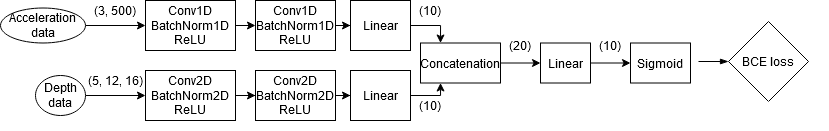